In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import KFold, cross_val_score,train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor

In [42]:
dtypes={
    'Price (in €)': float,
    'Total_area (square meters)': float,
    'Floor': float,
    'House_type': 'category',
    'Location_aprox': 'category',
    'Rooms': float,
    'Bathrooms': float
}
df = pd.read_csv("./Houses_final.csv", 
                 dtype=dtypes,
                 parse_dates=['submission_date'])


In [43]:
df.drop(columns=["Location","submission_date"],inplace=True)



In [44]:
df.dtypes

Total_area (square meters)     float64
Price (in €)                   float64
House_type                    category
Floor                          float64
Rooms                          float64
Bathrooms                      float64
Year_of_construction             int64
autonomous_heating               int64
central_heating                  int64
individual_heating               int64
no_heating                       int64
petrol_heating                   int64
natural_gas_heating              int64
LPG_heating                      int64
electrical_heating               int64
thermal_storage_heating          int64
wood_headting                    int64
pellet_heating                   int64
heat_pump_heating                int64
with_AC                          int64
with_storage_room                int64
with_elavator                    int64
with_solar_heater                int64
with_fireplace                   int64
Furnished                        int64
with_parking             

We will split our data in training and validation sets. But first let us encode the categorical features.

In [45]:
X=df.copy().drop(columns=["Price (in €)"])
y=df.copy().pop("Price (in €)")


In [66]:
def label_encode(df,one_hot=False):
    X = df.copy()
    if one_hot:
        cat_columns = X.select_dtypes(["category"]).columns
        X = pd.get_dummies(X, columns=cat_columns, drop_first=True,dtype=int)
        return X   
    else:
        for colname in X.select_dtypes(["category"]):
            X[colname] = X[colname].cat.codes
        return X
X= label_encode(X)

In [47]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

# Establishing a baseline

First we will establish a baseline model which we will use to evaluate our subsequent models. Notice that we use Round Mean Squared Logarithmic Error (RMSLE) is our cost function. There are many reasons for that. We mention the three most important ones here:

1)House prices are typically right-skewed. There are many affordable houses and fewer very expensive, luxury properties. This means the distribution of sale prices is not normal; it has a long tail towards higher values.

2)RMSE penalizes absolute errors. If you have a house priced at €100,000 and you're off by €10,000, that's an error of 10%. If you have a house priced at €1,000,000 and you're off by €10,000, that's an error of 1%. RMSE would treat both €10,000 errors equally, even though the relative impact is vastly different.

3)Log transformation "normalizes" the skewness. By taking the logarithm of the prices, the distribution often becomes more symmetrical (closer to a normal distribution). This is beneficial for many regression models that assume normally distributed errors or linear relationships.

In [48]:
def baseline_model(X, y,model=XGBRegressor()):

    log_y = np.log(y)
    score = cross_val_score(
        model, X, log_y, cv=5, scoring="neg_mean_squared_error",

    )
    score = -1 * score.mean()
    score = np.sqrt(score)
    return score
    

In [50]:
baseline=baseline_model(X_train, y_train)
print(f"Baseline RMSLE using Boosting: {baseline}")
print(f"Baseline RMSLE using Random Forest: {baseline_model(X_train, y_train, model=RandomForestRegressor())}")


Baseline RMSLE using Boosting: 0.24767440456288892
Baseline RMSLE using Random Forest: 0.2618548277940514


In [67]:
X_regr=label_encode(df.copy().drop(columns=["Price (in €)"]), one_hot=True)
X_regr_train,X_regr_test,y_regr_train,y_regr_test=train_test_split(X_regr,y,test_size=0.2,random_state=42)
print (f"Baseline RMSLE using Linear Regression: {baseline_model(X_regr_train, y_regr_train, model=LinearRegression())}")

Baseline RMSLE using Linear Regression: 0.3351185143921988


# Feature Engineering

In the next section we will try to engineer features that are going to improve the performance of our models.

It seems that Boosting is the most promising method to use for this problem so this will be our default. First we will use [mutual information](https://en.wikipedia.org/wiki/Mutual_information) to select features that are most relevant to the target variable which is the house price in our case.

In [31]:
def make_mi_scores(X, y):
    X = X.copy()

    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

In [32]:
mi_scores = round(make_mi_scores(X_train, y_train),2)



In [33]:
print(mi_scores)

Total_area (square meters)    1.03
Year_of_construction          0.47
Rooms                         0.40
Location_aprox                0.39
Floor                         0.29
House_type                    0.28
Bathrooms                     0.19
with_fireplace                0.14
with_parking                  0.10
with_garden                   0.08
with_storage_room             0.07
with_elavator                 0.06
natural_gas_heating           0.05
Furnished                     0.04
electrical_heating            0.04
last_floor                    0.03
petrol_heating                0.03
with_balcony                  0.03
with_solar_heater             0.02
individual_heating            0.02
autonomous_heating            0.02
with_AC                       0.02
no_heating                    0.02
central_heating               0.01
heat_pump_heating             0.01
thermal_storage_heating       0.01
with_pool                     0.00
LPG_heating                   0.00
wood_headting       

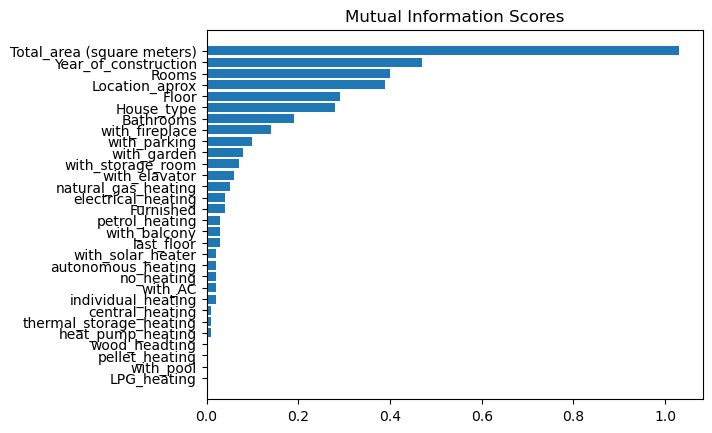

In [34]:

plot_mi_scores(mi_scores)

We drop the features with mutual information zero. Notice though that the error did not improve much.

In [35]:
def drop_uninformative(df, mi_scores):
    return df.loc[:, mi_scores > 0.0]

In [ ]:
X = X_train.copy()

X_no_uninform = drop_uninformative(X, mi_scores)

print(baseline_model(X_no_uninform, y_train))

0.24797996101642433


We will also draw the correlation matrix to visualize the relationships between features.

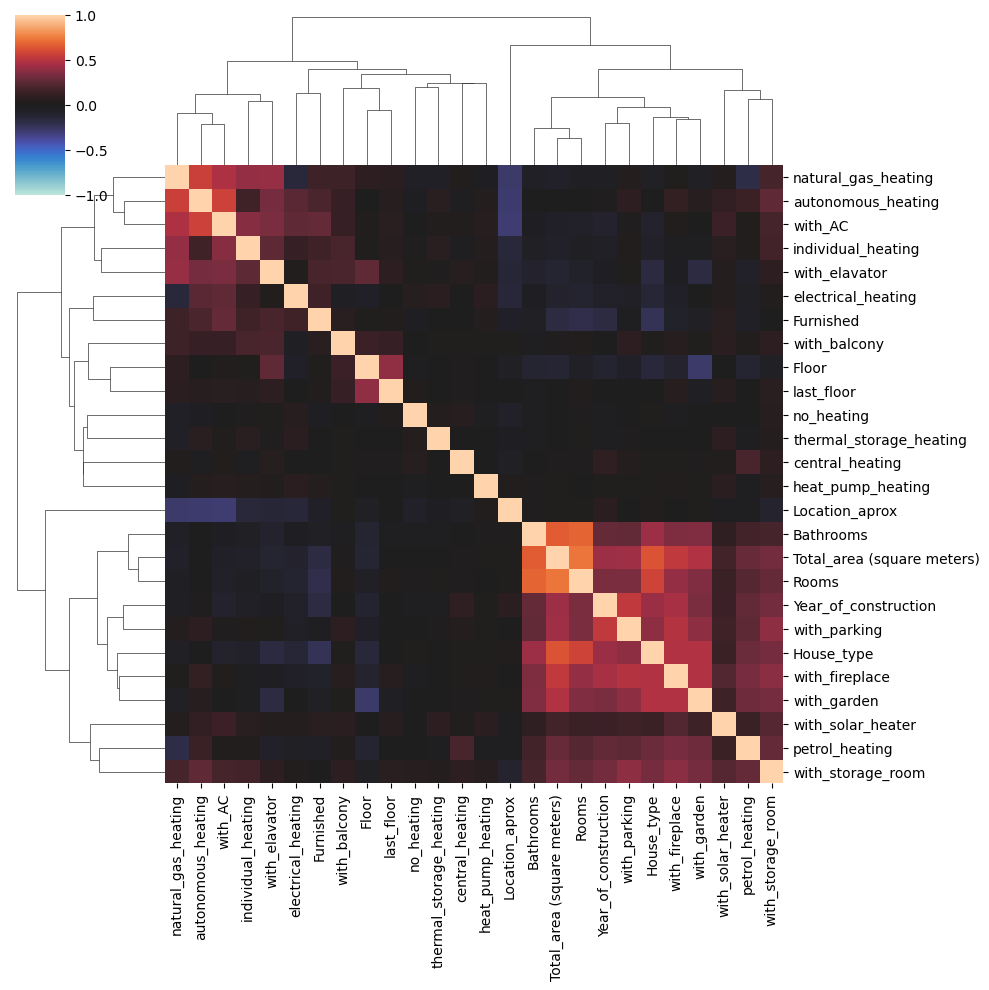

In [ ]:
def corrplot(df, method="pearson", annot=True, **kwargs):
    sns.clustermap(
        df.corr(method, numeric_only=True),
        vmin=-1.0,
        vmax=1.0,
        cmap="icefire",
        method="complete",
        annot=annot,
        **kwargs,
    )


corrplot(X_no_uninform, annot=None)


Next we will develop our feature set. We are going to create functions that will add features to our data set. We describe what each function does.

**counts:** This functions simply counts the number of attributes from the list 
        "with_AC",
        "with_storage_room",
        "with_elavator",
        "with_solar_heater",
        "with_fireplace",
        "with_parking",
        "with_garden",
        "with_pool",
        "with_balcony",
        "last_floor" 
each house has and returns a column with that number.

**group_transforms:** This function creates a new column which contains the average total area of houses located in the same place (location_aprox column) as the specified row.

In [ ]:
def counts(df):
    X = pd.DataFrame()
    X["Number_of_extras"] = df[[
        "with_AC",
        "with_storage_room",
        "with_elavator",
        "with_solar_heater",
        "with_fireplace",
        "with_parking",
        "with_garden",
        "with_pool",
        "with_balcony",
        "last_floor"
    ]].sum(axis=1)
    return X
def group_transforms(df):
    X = pd.DataFrame()
    X["Mean_total_area_per_loc"] = df.groupby("Location_aprox")["Total_area"].transform("mean")
    return X

In [68]:
X_train

,Total_area (square meters),House_type,Floor,Rooms,Bathrooms,Year_of_construction,autonomous_heating,central_heating,individual_heating,no_heating,...,with_elavator,with_solar_heater,with_fireplace,Furnished,with_parking,with_garden,with_pool,with_balcony,last_floor,Location_aprox
3714,36.0,3,1.0,1.0,1.0,1965,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
18266,56.0,3,2.0,1.0,1.0,1987,1,0,0,0,...,0,1,0,0,0,0,0,1,0,17
22693,120.0,6,3.0,1.0,1.0,2007,1,0,0,0,...,0,0,1,0,1,1,0,0,0,12
2305,95.0,3,1.0,4.0,1.0,1963,0,0,1,0,...,1,0,0,0,0,0,0,1,0,22
21093,100.0,6,1.0,3.0,2.0,2003,0,0,0,0,...,0,0,1,0,1,0,0,1,0,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21575,88.0,3,3.0,2.0,1.0,2005,0,1,0,0,...,1,0,0,0,1,0,0,1,0,8
5390,65.0,3,4.0,1.0,1.0,1966,1,0,0,1,...,1,0,0,0,0,0,0,1,0,5
860,170.0,7,1.0,4.0,2.0,1960,0,0,0,0,...,0,0,0,0,0,0,0,0,0,24
15795,37.0,1,5.0,1.0,1.0,1979,1,0,0,0,...,1,0,0,1,0,0,0,1,1,0


It is time now to create the desired features and add them to our data. Putting the transformations into separate functions makes it easier to experiment with various combinations. We always check whether the added features improves the model.

In [ ]:
def create_features(df, df_test=None):
    X = df.copy()
    y = X.pop("SalePrice")
    mi_scores = make_mi_scores(X, y)

    # Combine splits if test data is given
    #
    # If we're creating features for test set predictions, we should
    # use all the data we have available. After creating our features,
    # we'll recreate the splits.
    if df_test is not None:
        X_test = df_test.copy()
        X_test.pop("SalePrice")
        X = pd.concat([X, X_test])

    # Lesson 2 - Mutual Information
    X = drop_uninformative(X, mi_scores)

    # Lesson 3 - Transformations
    X = X.join(mathematical_transforms(X))
    X = X.join(interactions(X))
    X = X.join(counts(X))
    # X = X.join(break_down(X))
    X = X.join(group_transforms(X))

    # Lesson 4 - Clustering
    # X = X.join(cluster_labels(X, cluster_features, n_clusters=20))
    # X = X.join(cluster_distance(X, cluster_features, n_clusters=20))

    # Lesson 5 - PCA
    X = X.join(pca_inspired(X))
    # X = X.join(pca_components(X, pca_features))
    # X = X.join(indicate_outliers(X))

    X = label_encode(X)

    # Reform splits
    if df_test is not None:
        X_test = X.loc[df_test.index, :]
        X.drop(df_test.index, inplace=True)

    # Lesson 6 - Target Encoder
    encoder = CrossFoldEncoder(MEstimateEncoder, m=1)
    X = X.join(encoder.fit_transform(X, y, cols=["MSSubClass"]))
    if df_test is not None:
        X_test = X_test.join(encoder.transform(X_test))

    if df_test is not None:
        return X, X_test
    else:
        return X


df_train, df_test = load_data()
X_train = create_features(df_train)
y_train = df_train.loc[:, "SalePrice"]

score_dataset(X_train, y_train)

In [ ]:
df2

,Total_area (square meters),Price (in €),Floor,Rooms,Bathrooms,Year_of_construction,House_type_Loft,House_type_Studio / Γκαρσονιέρα,House_type_Βίλα,House_type_Διαμέρισμα,...,Location_aprox_Sindos_Diavata,Location_aprox_Stavroupoli,Location_aprox_Sykies,Location_aprox_Thermi,Location_aprox_Toumpa,Location_aprox_Triandria,Location_aprox_Vardaris_xirokrini,Location_aprox_Voulgari_Ntepo,Location_aprox_Xarilaou,Location_aprox_out_of_thessaloniki
0,170.0,2700000.0,7.0,3.0,2.0,1952.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,70.0,245000.0,7.0,2.0,1.0,1952.0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
2,70.0,245000.0,7.0,2.0,1.0,1952.0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,70.0,245000.0,7.0,2.0,1.0,1952.0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
4,71.0,290000.0,1.0,2.0,1.0,1952.0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63026,138.0,485000.0,8.0,4.0,2.0,2022.0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
63027,156.0,370000.0,6.0,2.0,1.0,2022.0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
63028,87.0,180000.0,1.0,2.0,1.0,2022.0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
63029,153.0,370000.0,6.0,4.0,1.0,2022.0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [5]:
df_grouped_loc=df.groupby("Location_aprox")

In [6]:
df_grouped_loc.count()

,Total_area,Price,House_type,Floor,Rooms,Bathrooms,Year_of_construction
Location_aprox,,,,,,,
Agia_triada,3072,3072,3072,3072,3072,3072,3072
Ampelokipoi,918,918,918,918,918,918,918
Analipsi,2645,2645,2645,2645,2645,2645,2645
Ano_poli_Evaggelistria,1859,1859,1859,1859,1859,1859,1859
Center_east_of_aristotle_square,5818,5818,5818,5818,5818,5818,5818
Center_west_of_including_aristotle_square,5429,5429,5429,5429,5429,5429,5429
Efkarpia_Nikopoli,467,467,467,467,467,467,467
Evosmos_Kordelio,2644,2644,2644,2644,2644,2644,2644
Kalamaria,4589,4589,4589,4589,4589,4589,4589


<Axes: xlabel='Price', ylabel='Location_aprox'>

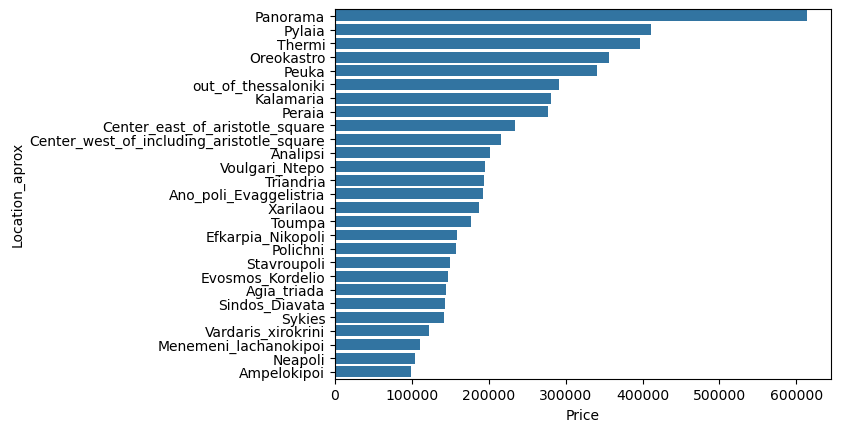

In [7]:
mean_loc=df.groupby("Location_aprox")["Price"].mean().sort_values(ascending=False)
mean_loc=mean_loc.reset_index()
sns.barplot(y="Location_aprox",x="Price",data=mean_loc)

<Axes: xlabel='Total_area', ylabel='Location_aprox'>

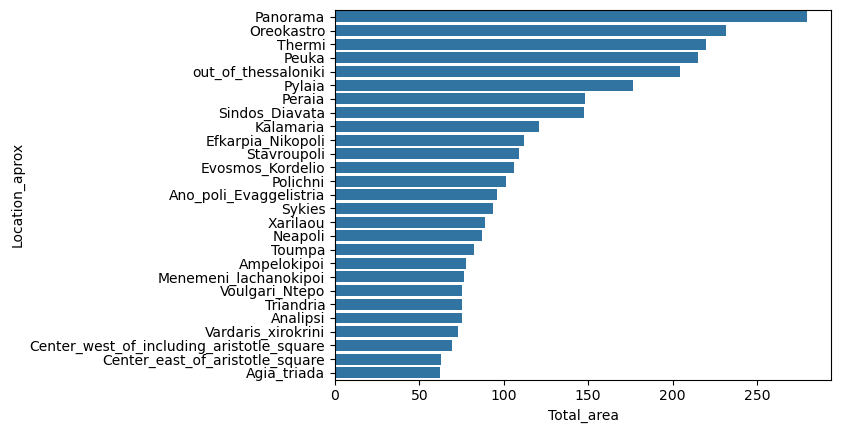

In [8]:
mean_area=df_grouped_loc["Total_area"].mean().sort_values(ascending=False)
mean_area=mean_area.reset_index()
sns.barplot(y="Location_aprox",x="Total_area",data=mean_area)

In [9]:
cor=df[["Total_area","Price","Floor","Rooms","Bathrooms"]].corr()
cor

,Total_area,Price,Floor,Rooms,Bathrooms
Total_area,1.000000,0.756536,-0.300886,0.781411,0.699426
Price,0.756536,1.000000,-0.078852,0.622391,0.587061
Floor,-0.300886,-0.078852,1.000000,-0.249955,-0.265017
Rooms,0.781411,0.622391,-0.249955,1.000000,0.718399
Bathrooms,0.699426,0.587061,-0.265017,0.718399,1.000000


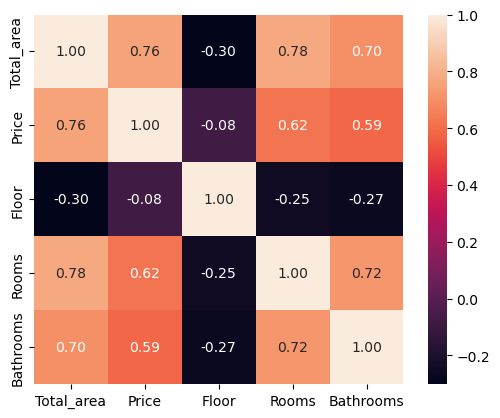

In [10]:
hm=sns.heatmap(cor,cbar=True,
                annot=True,
                square=True,
                fmt='.2f')

In [11]:
df_grouped_loc["Year_of_construction"].mean().sort_values(ascending=False)

Location_aprox
Thermi                                       2004.693126
Peuka                                        2003.254848
Pylaia                                       2003.153361
Oreokastro                                   1999.702128
Efkarpia_Nikopoli                            1998.743041
out_of_thessaloniki                          1998.034510
Panorama                                     1997.727422
Evosmos_Kordelio                             1997.671710
Polichni                                     1995.458869
Sindos_Diavata                               1995.151515
Peraia                                       1994.760201
Stavroupoli                                  1991.413103
Kalamaria                                    1990.150795
Sykies                                       1989.445391
Menemeni_lachanokipoi                        1987.061135
Ano_poli_Evaggelistria                       1986.594944
Triandria                                    1985.580247
Xarilaou        

In [12]:
df["price_per_square_meter"]=df["Price"]/df["Total_area"]

In [13]:
df

,Total_area,Price,House_type,Floor,Rooms,Bathrooms,Year_of_construction,Location_aprox,price_per_square_meter
0,170.0,2700000.0,Μεζονέτα,7.0,3.0,2.0,1952.0,Center_east_of_aristotle_square,15882.352941
1,70.0,245000.0,Διαμέρισμα,7.0,2.0,1.0,1952.0,Vardaris_xirokrini,3500.000000
2,70.0,245000.0,Διαμέρισμα,7.0,2.0,1.0,1952.0,Center_west_of_including_aristotle_square,3500.000000
3,70.0,245000.0,Διαμέρισμα,7.0,2.0,1.0,1952.0,Vardaris_xirokrini,3500.000000
4,71.0,290000.0,Διαμέρισμα,1.0,2.0,1.0,1952.0,Center_east_of_aristotle_square,4084.507042
...,...,...,...,...,...,...,...,...,...
63026,138.0,485000.0,Μεζονέτα,8.0,4.0,2.0,2022.0,Toumpa,3514.492754
63027,156.0,370000.0,Μεζονέτα,6.0,2.0,1.0,2022.0,Toumpa,2371.794872
63028,87.0,180000.0,Διαμέρισμα,1.0,2.0,1.0,2022.0,Evosmos_Kordelio,2068.965517
63029,153.0,370000.0,Μεζονέτα,6.0,4.0,1.0,2022.0,Triandria,2418.300654


In [14]:
df.groupby("Location_aprox")["price_per_square_meter"].mean().sort_values(ascending=False)

Location_aprox
Peraia                                       8710.070658
Thermi                                       5603.969815
Center_east_of_aristotle_square              3747.371232
Pylaia                                       3703.199739
Center_west_of_including_aristotle_square    3146.812020
Vardaris_xirokrini                           3085.884097
Triandria                                    2669.563227
Voulgari_Ntepo                               2667.086578
out_of_thessaloniki                          2639.327120
Analipsi                                     2621.103570
Panorama                                     2577.151172
Agia_triada                                  2397.797565
Kalamaria                                    2328.541260
Toumpa                                       2210.518881
Xarilaou                                     2170.014177
Oreokastro                                   1988.204800
Ano_poli_Evaggelistria                       1987.528410
Polichni        

In [88]:
df2.columns


Index(['Total_area (square meters)', 'Price (in €)', 'Floor', 'Rooms',
       'Bathrooms', 'Year_of_construction', 'House_type_Loft',
       'House_type_Studio / Γκαρσονιέρα', 'House_type_Βίλα',
       'House_type_Διαμέρισμα', 'House_type_Κτίριο',
       'House_type_Λοιπές κατηγορίες', 'House_type_Μεζονέτα',
       'House_type_Μονοκατοικία', 'House_type_Συγκρότημα διαμερισμάτων',
       'Location_aprox_Agia_triada', 'Location_aprox_Ampelokipoi',
       'Location_aprox_Analipsi', 'Location_aprox_Ano_poli_Evaggelistria',
       'Location_aprox_Center_east_of_aristotle_square',
       'Location_aprox_Center_west_of_including_aristotle_square',
       'Location_aprox_Efkarpia_Nikopoli', 'Location_aprox_Evosmos_Kordelio',
       'Location_aprox_Kalamaria', 'Location_aprox_Menemeni_lachanokipoi',
       'Location_aprox_Neapoli', 'Location_aprox_Oreokastro',
       'Location_aprox_Panorama', 'Location_aprox_Peraia',
       'Location_aprox_Peuka', 'Location_aprox_Polichni',
       'Location_ap

In [15]:
X=df2.drop(columns=["Price (in €)"])
Y=df2["Price (in €)"].to_numpy()
Y


array([2700000.,  245000.,  245000., ...,  180000.,  370000.,  200000.])

In [16]:
X.columns

Index(['Total_area (square meters)', 'Floor', 'Rooms', 'Bathrooms',
       'Year_of_construction', 'House_type_Loft',
       'House_type_Studio / Γκαρσονιέρα', 'House_type_Βίλα',
       'House_type_Διαμέρισμα', 'House_type_Κτίριο',
       'House_type_Λοιπές κατηγορίες', 'House_type_Μεζονέτα',
       'House_type_Μονοκατοικία', 'House_type_Συγκρότημα διαμερισμάτων',
       'Location_aprox_Agia_triada', 'Location_aprox_Ampelokipoi',
       'Location_aprox_Analipsi', 'Location_aprox_Ano_poli_Evaggelistria',
       'Location_aprox_Center_east_of_aristotle_square',
       'Location_aprox_Center_west_of_including_aristotle_square',
       'Location_aprox_Efkarpia_Nikopoli', 'Location_aprox_Evosmos_Kordelio',
       'Location_aprox_Kalamaria', 'Location_aprox_Menemeni_lachanokipoi',
       'Location_aprox_Neapoli', 'Location_aprox_Oreokastro',
       'Location_aprox_Panorama', 'Location_aprox_Peraia',
       'Location_aprox_Peuka', 'Location_aprox_Polichni',
       'Location_aprox_Pylaia', 'Lo

In [17]:
X_numeric=X[['Total_area (square meters)', 'Floor', 'Rooms', 'Bathrooms',
       'Year_of_construction']]
X_catergorical=X[['House_type_Loft',
       'House_type_Studio / Γκαρσονιέρα', 'House_type_Βίλα',
       'House_type_Διαμέρισμα', 'House_type_Κτίριο',
       'House_type_Λοιπές κατηγορίες', 'House_type_Μεζονέτα',
       'House_type_Μονοκατοικία', 'House_type_Συγκρότημα διαμερισμάτων',
       'Location_aprox_Agia_triada', 'Location_aprox_Ampelokipoi',
       'Location_aprox_Analipsi', 'Location_aprox_Ano_poli_Evaggelistria',
       'Location_aprox_Center_east_of_aristotle_square',
       'Location_aprox_Center_west_of_including_aristotle_square',
       'Location_aprox_Efkarpia_Nikopoli', 'Location_aprox_Evosmos_Kordelio',
       'Location_aprox_Kalamaria', 'Location_aprox_Menemeni_lachanokipoi',
       'Location_aprox_Neapoli', 'Location_aprox_Oreokastro',
       'Location_aprox_Panorama', 'Location_aprox_Peraia',
       'Location_aprox_Peuka', 'Location_aprox_Polichni',
       'Location_aprox_Pylaia', 'Location_aprox_Sindos_Diavata',
       'Location_aprox_Stavroupoli', 'Location_aprox_Sykies',
       'Location_aprox_Thermi', 'Location_aprox_Toumpa',
       'Location_aprox_Triandria', 'Location_aprox_Vardaris_xirokrini',
       'Location_aprox_Voulgari_Ntepo', 'Location_aprox_Xarilaou',
       'Location_aprox_out_of_thessaloniki']]
X_numeric

,Total_area (square meters),Floor,Rooms,Bathrooms,Year_of_construction
0,170.0,7.0,3.0,2.0,1952.0
1,70.0,7.0,2.0,1.0,1952.0
2,70.0,7.0,2.0,1.0,1952.0
3,70.0,7.0,2.0,1.0,1952.0
4,71.0,1.0,2.0,1.0,1952.0
...,...,...,...,...,...
63026,138.0,8.0,4.0,2.0,2022.0
63027,156.0,6.0,2.0,1.0,2022.0
63028,87.0,1.0,2.0,1.0,2022.0
63029,153.0,6.0,4.0,1.0,2022.0


In [18]:
transform = preprocessing.StandardScaler()
X_numeric=transform.fit(X_numeric).transform(X_numeric)
X_numeric=pd.DataFrame(X_numeric,columns=['Total_area (square meters)', 'Floor', 'Rooms', 'Bathrooms',
       'Year_of_construction'])


In [43]:
def NormalizeData(data):
    transform = preprocessing.StandardScaler()
    data_normalized=transform.fit(data).transform(data)
    data_normalized=pd.DataFrame(data_normalized,columns=['Total_area (square meters)', 'Price (in €)', 'Floor', 'Rooms',
       'Bathrooms', 'Year_of_construction', 
       'House_type_Studio / Γκαρσονιέρα', 'House_type_Βίλα',
       'House_type_Διαμέρισμα', 'House_type_Κτίριο',
       'House_type_Λοιπές κατηγορίες', 'House_type_Μεζονέτα',
       'House_type_Μονοκατοικία', 'House_type_Συγκρότημα διαμερισμάτων',
       'Location_aprox_Agia_triada', 'Location_aprox_Ampelokipoi',
       'Location_aprox_Analipsi', 'Location_aprox_Ano_poli_Evaggelistria',
       'Location_aprox_Center_east_of_aristotle_square',
       'Location_aprox_Center_west_of_including_aristotle_square',
       'Location_aprox_Efkarpia_Nikopoli', 'Location_aprox_Evosmos_Kordelio',
       'Location_aprox_Kalamaria', 'Location_aprox_Menemeni_lachanokipoi',
       'Location_aprox_Neapoli', 'Location_aprox_Oreokastro',
       'Location_aprox_Panorama', 'Location_aprox_Peraia',
       'Location_aprox_Peuka', 'Location_aprox_Polichni',
       'Location_aprox_Pylaia', 'Location_aprox_Sindos_Diavata',
       'Location_aprox_Stavroupoli', 'Location_aprox_Sykies',
       'Location_aprox_Thermi', 'Location_aprox_Toumpa',
       'Location_aprox_Triandria', 'Location_aprox_Vardaris_xirokrini',
       'Location_aprox_Voulgari_Ntepo', 'Location_aprox_Xarilaou',
       'Location_aprox_out_of_thessaloniki'])
    return(data_normalized)

In [19]:
X_catergorical.to_numpy()
X_normalized=np.concatenate([X_numeric,X_catergorical],axis=1)
#fit_Y=transform.fit(Y)

In [20]:
X_normalized

array([[ 0.53870753,  2.54521972,  0.46547316, ...,  0.        ,
         0.        ,  0.        ],
       [-0.49793861,  2.54521972, -0.2840667 , ...,  0.        ,
         0.        ,  0.        ],
       [-0.49793861,  2.54521972, -0.2840667 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.32170877, -0.5890529 , -0.2840667 , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.36247768,  2.02284095,  1.21501303, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.02038446,  1.50046218,  0.46547316, ...,  0.        ,
         0.        ,  0.        ]])

In [21]:
X_train,X_test,Y_train,Y_test=model_selection.train_test_split(X_normalized,Y,test_size=0.1)

In [22]:
reg=linear_model.LinearRegression()
reg.fit(X_train,Y_train)


LinearRegression()

In [23]:
reg.score(X_test,Y_test)

0.6860925355950582

In [24]:
y_pred=reg.predict(X_test)

In [26]:
metrics.r2_score(Y_test,y_pred)

0.6860925355950582

In [27]:
df2_normalized=transform.fit(df2).transform(df2)
df2_normalized.shape

(63031, 42)

In [28]:
df2_normalized=pd.DataFrame(df2_normalized,columns=['Total_area (square meters)', 'Price (in €)', 'Floor', 'Rooms',
       'Bathrooms', 'Year_of_construction', 'House_type_Loft',
       'House_type_Studio / Γκαρσονιέρα', 'House_type_Βίλα',
       'House_type_Διαμέρισμα', 'House_type_Κτίριο',
       'House_type_Λοιπές κατηγορίες', 'House_type_Μεζονέτα',
       'House_type_Μονοκατοικία', 'House_type_Συγκρότημα διαμερισμάτων',
       'Location_aprox_Agia_triada', 'Location_aprox_Ampelokipoi',
       'Location_aprox_Analipsi', 'Location_aprox_Ano_poli_Evaggelistria',
       'Location_aprox_Center_east_of_aristotle_square',
       'Location_aprox_Center_west_of_including_aristotle_square',
       'Location_aprox_Efkarpia_Nikopoli', 'Location_aprox_Evosmos_Kordelio',
       'Location_aprox_Kalamaria', 'Location_aprox_Menemeni_lachanokipoi',
       'Location_aprox_Neapoli', 'Location_aprox_Oreokastro',
       'Location_aprox_Panorama', 'Location_aprox_Peraia',
       'Location_aprox_Peuka', 'Location_aprox_Polichni',
       'Location_aprox_Pylaia', 'Location_aprox_Sindos_Diavata',
       'Location_aprox_Stavroupoli', 'Location_aprox_Sykies',
       'Location_aprox_Thermi', 'Location_aprox_Toumpa',
       'Location_aprox_Triandria', 'Location_aprox_Vardaris_xirokrini',
       'Location_aprox_Voulgari_Ntepo', 'Location_aprox_Xarilaou',
       'Location_aprox_out_of_thessaloniki'])

In [29]:
X1_normalized=df2_normalized.drop(columns=['Price (in €)'])
y1_normalized=df2_normalized["Price (in €)"]

In [ ]:
X1_train,X1_test,Y1_train,Y1_test=model_selection.train_test_split(X1_normalized,y1_normalized,test_size=0.1)


In [31]:
reg=linear_model.LinearRegression()
reg.fit(X1_train,Y1_train)

LinearRegression()

In [46]:
def test__train_split(data):
    x_norm=data.drop(columns=['Price (in €)'])
    y_norm=data["Price (in €)"]
    X_train,X_test,Y_train,Y_test=model_selection.train_test_split(x_norm,y_norm,test_size=0.1)
    return(X_train,X_test,Y_train,Y_test)

In [32]:
reg.score(X1_test,Y1_test)

0.7082385132145271

In [55]:
df3_norm=NormalizeData(df3)
df3_norm.columns

Index(['Total_area (square meters)', 'Price (in €)', 'Floor', 'Rooms',
       'Bathrooms', 'Year_of_construction', 'House_type_Studio / Γκαρσονιέρα',
       'House_type_Βίλα', 'House_type_Διαμέρισμα', 'House_type_Κτίριο',
       'House_type_Λοιπές κατηγορίες', 'House_type_Μεζονέτα',
       'House_type_Μονοκατοικία', 'House_type_Συγκρότημα διαμερισμάτων',
       'Location_aprox_Agia_triada', 'Location_aprox_Ampelokipoi',
       'Location_aprox_Analipsi', 'Location_aprox_Ano_poli_Evaggelistria',
       'Location_aprox_Center_east_of_aristotle_square',
       'Location_aprox_Center_west_of_including_aristotle_square',
       'Location_aprox_Efkarpia_Nikopoli', 'Location_aprox_Evosmos_Kordelio',
       'Location_aprox_Kalamaria', 'Location_aprox_Menemeni_lachanokipoi',
       'Location_aprox_Neapoli', 'Location_aprox_Oreokastro',
       'Location_aprox_Panorama', 'Location_aprox_Peraia',
       'Location_aprox_Peuka', 'Location_aprox_Polichni',
       'Location_aprox_Pylaia', 'Location_apr

In [57]:
df3_norm.drop(columns=["Location_aprox_Sindos_Diavata"],inplace=True)

In [58]:
x3_train,x3_test,y3_train,y3_test=test__train_split(df3_norm)

In [59]:
reg.fit(x3_train,y3_train)

LinearRegression()

In [60]:
reg.score(x3_test,y3_test)

0.6610098573800862

In [62]:
reg_tree=tree.DecisionTreeRegressor()
reg_tree.fit(X1_train,Y1_train)

DecisionTreeRegressor()

In [63]:
reg_tree.score(X1_test,Y1_test)

0.9801487767756586

In [26]:
import numpy as np
a=np.array([[1,2,3],[2,6,41],[3,4,5]])
b=np.mean(a,axis=0)

In [38]:
a[:,[2,1,0]]

array([[ 3,  2,  1],
       [41,  6,  2],
       [ 5,  4,  3]])

In [28]:
a-b

array([[ -1.        ,  -2.        , -13.33333333],
       [  0.        ,   2.        ,  24.66666667],
       [  1.        ,   0.        , -11.33333333]])

In [29]:
np.sort(b)

array([ 2.        ,  4.        , 16.33333333])

In [37]:
b[::2]

array([ 2.        , 16.33333333])